In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import sqlite3
from flask import Flask, render_template, request, jsonify
import plotly.express as px

In [25]:
#Alphavantage URL is defined below to use the Alphavantage API for data collection
api_key = "M0H1JZNA6VMOG30H"
alphavantage_url = "https://www.alphavantage.co/query?"

# Bank of Canada API URL is set-up for fetching inflation data
inlflation_url = "https://www.bankofcanada.ca/valet/observations/V41690914/json"
response_inflation = requests.get(inlflation_url)

In [32]:
# Since data was insufficiently available on Yahoo Finance, iShares ETF data for the index has been pulled from Alphavantage instead
url_tsx = (f"{alphavantage_url}function=TIME_SERIES_DAILY&symbol=XIU.TO&outputsize=full&extended_hours=false&apikey={api_key}&datatype=csv")
url_ttfs = (f"{alphavantage_url}function=TIME_SERIES_DAILY&symbol=XFN.TO&outputsize=full&extended_hours=false&apikey={api_key}&datatype=csv")
url_tten = (f"{alphavantage_url}function=TIME_SERIES_DAILY&symbol=XEG.TO&outputsize=full&extended_hours=false&apikey={api_key}&datatype=csv")
url_ttin = (f"{alphavantage_url}function=TIME_SERIES_DAILY&symbol=ZIN.TO&outputsize=full&extended_hours=false&apikey={api_key}&datatype=csv")
url_ttma = (f"{alphavantage_url}function=TIME_SERIES_DAILY&symbol=XMA.TO&outputsize=full&extended_hours=false&apikey={api_key}&datatype=csv")
url_ttit = (f"{alphavantage_url}function=TIME_SERIES_DAILY&symbol=XIT.TO&outputsize=full&extended_hours=false&apikey={api_key}&datatype=csv")

In [33]:
# The read_csv function is used to read the data via the APIs above, the data is converted to dataframes and varaibles relative to the sectors are defined below.
df_tsx = pd.read_csv(url_tsx)
df_financial = pd.read_csv(url_ttfs)
df_energy = pd.read_csv(url_tten)
df_industrials = pd.read_csv(url_ttin)
df_materials = pd.read_csv(url_ttma)
df_technology = pd.read_csv(url_ttit)

In [29]:
# Data is saved to CSVs for analysis
df_tsx.to_csv("TSX.csv")
df_financial.to_csv("Financial Sector.csv")
df_energy.to_csv("Energy Sector.csv")
df_industrials.to_csv("Industrials Sector.csv")
df_materials.to_csv("Materials Sector.csv")
df_technology.to_csv("IT Sector.csv")

In [34]:
# Timestamp column in csv files is converted to datetime format, to help clean the data
df_tsx['timestamp'] = pd.to_datetime(df_tsx['timestamp'])
df_financial['timestamp'] = pd.to_datetime(df_financial['timestamp'])
df_energy['timestamp'] = pd.to_datetime(df_energy['timestamp'])
df_industrials['timestamp'] = pd.to_datetime(df_industrials['timestamp'])
df_materials['timestamp'] = pd.to_datetime(df_materials['timestamp'])
df_technology['timestamp'] = pd.to_datetime(df_technology['timestamp'])

# Data is cleaned as per the time period of the analysis by defining the start and end dates below
start_date = '2020-01-01'
end_date = '2024-12-31'

# The dataFrame is filtered for the above specified date range
clean_df_tsx = df_tsx[(df_tsx['timestamp'] >= start_date) & (df_tsx['timestamp'] <= end_date)]
clean_df_financial = df_financial[(df_financial['timestamp'] >= start_date) & (df_financial['timestamp'] <= end_date)]
clean_df_energy = df_energy[(df_energy['timestamp'] >= start_date) & (df_energy['timestamp'] <= end_date)]
clean_df_industrials = df_industrials[(df_industrials['timestamp'] >= start_date) & (df_industrials['timestamp'] <= end_date)]
clean_df_materials = df_materials[(df_materials['timestamp'] >= start_date) & (df_materials['timestamp'] <= end_date)]
clean_df_technology = df_technology[(df_technology['timestamp'] >= start_date) & (df_technology['timestamp'] <= end_date)]


In [12]:
# The cleaned data is now saved to CSVs
clean_df_tsx.to_csv("TSX.csv")
clean_df_financial.to_csv("Financial Sector.csv")
clean_df_energy.to_csv("Energy Sector.csv")
clean_df_industrials.to_csv("Industrials Sector.csv")
clean_df_materials.to_csv("Materials Sector.csv")
clean_df_technology.to_csv("IT Sector.csv")

In [35]:
# Inflation data is sourced via the Bank of Canada API set up earlier
data = response_inflation.json()

# Extract observations (GDP data)
observations = data['observations']

cpi_data = pd.DataFrame(observations)

# Extract relevant fields: date and CPI value
cpi_data['date'] = pd.to_datetime(cpi_data['d'])  # Convert 'd' to datetime - d column stores the relevant dates for the required data
cpi_data['CPI'] = cpi_data['V41690914'].apply(lambda x: x['v']).astype(float)  # Extract 'v' from 'V41690914', as this column stores the cpi data

# Keep only relevant columns
cpi_data = cpi_data[['date', 'CPI']]

# Filter data for 2019 onwards
cpi_data = cpi_data[cpi_data['date'] >= '1999-01-01']

# The pct_change(12) function is used on the monthly CPI data, to compound it over 12 months and obtain the annualized infaltion 
cpi_data['Inflation Rate (%)'] = cpi_data['CPI'].pct_change(12) * 100

cpi_data.to_csv("canadian_inflation.csv")

In [2]:
conn = sqlite3.connect("tsx_analysis.db")
cursor = conn.cursor()

In [3]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS tsx_daily (
    date TEXT PRIMARY KEY,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    volume INTEGER
)
""")

In [12]:
# Reading the TSX data saved earlier for further analysis

tsx_data = pd.read_csv("Resources\Alphavantage\TSX.csv")
energy_sector = pd.read_csv("Resources\Alphavantage\Energy Sector.csv")
financial_sector = pd.read_csv("Resources\Alphavantage\Financial Sector.csv")
industrial_sector = pd.read_csv("Resources\Alphavantage\Industrials Sector.csv")
IT_sector = pd.read_csv("Resources\Alphavantage\IT Sector.csv")
materials_sector = pd.read_csv("Resources\Alphavantage\Materials Sector.csv")


In [13]:
# Reading the macroeconomic data collected earlier
fx_data = pd.read_csv("Resources\CADUSD_Historical_Monthly.csv")
inflation_data = pd.read_csv("Resources\Bank of Canada\canadian_inflation_annualized.csv")


In [37]:
# Loading the data to SQLite table
tsx_data.to_sql("tsx_daily", conn, if_exists="replace", index=False)
energy_sector.to_sql("energy_sector", conn, if_exists="replace", index=False)
financial_sector.to_sql("financial_sector", conn, if_exists="replace", index=False)
industrial_sector.to_sql("industrial_sector", conn, if_exists="replace", index=False)
IT_sector.to_sql("IT_sector", conn, if_exists="replace", index=False)
materials_sector.to_sql("materials_sector", conn, if_exists="replace", index=False)


1250

In [6]:
fx_data.to_sql("fx_data", conn, if_exists="replace", index=False)
inflation_data.to_sql("CPI_Inflation", conn, if_exists="replace", index=False)


71

In [18]:
inflation_data.rename(columns={'date': 'timestamp'}, inplace=True)

In [13]:
# The timestamp column is defined as datetime
tsx_data['timestamp'] = pd.to_datetime(tsx_data['timestamp'])
energy_sector['timestamp'] = pd.to_datetime(energy_sector['timestamp'])
financial_sector['timestamp'] = pd.to_datetime(financial_sector['timestamp'])
industrial_sector['timestamp'] = pd.to_datetime(industrial_sector['timestamp'])
IT_sector['timestamp'] = pd.to_datetime(IT_sector['timestamp'])
materials_sector['timestamp'] = pd.to_datetime(materials_sector['timestamp'])

NameError: name 'tsx_data' is not defined

In [19]:
# Similarly to TSX data earlier, macroeconomic data timestamp is also coverted to Datetime format

inflation_data['timestamp'] = pd.to_datetime(inflation_data['timestamp'])
fx_data['timestamp'] = pd.to_datetime(fx_data['timestamp'])

In [46]:
# Data is cleaned to remove blank columns

for df in [tsx_data, energy_sector, financial_sector, industrial_sector, IT_sector, materials_sector]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

In [48]:
# The cleaned data is updated to SQLite

tsx_data.to_sql("tsx_daily", conn, if_exists="replace", index=False)
energy_sector.to_sql("energy_sector", conn, if_exists="replace", index=False)
financial_sector.to_sql("financial_sector", conn, if_exists="replace", index=False)
industrial_sector.to_sql("industrial_sector", conn, if_exists="replace", index=False)
IT_sector.to_sql("IT_sector", conn, if_exists="replace", index=False)
materials_sector.to_sql("materials_sector", conn, if_exists="replace", index=False)

1250

In [14]:
tsx_query = pd.read_sql("SELECT * FROM tsx_daily LIMIT 5;", conn)
print(tsx_query)

             timestamp   open   high    low  close    volume
0  2024-12-20 00:00:00  36.75  37.45  36.73  37.26  31832200
1  2024-12-19 00:00:00  37.34  37.36  36.98  37.00   4927900
2  2024-12-18 00:00:00  38.05  38.07  37.16  37.23   5660300
3  2024-12-17 00:00:00  37.99  38.11  37.92  38.09   3031700
4  2024-12-16 00:00:00  38.27  38.27  38.08  38.10   1723400


In [16]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('tsx_daily',), ('energy_sector',), ('financial_sector',), ('industrial_sector',), ('IT_sector',), ('materials_sector',), ('fx_data',), ('CPI_Inflation',)]


In [17]:
# Fetch data for all sectors, to plot line chart

tsx_data = pd.read_sql("SELECT timestamp, close FROM tsx_daily;", conn)
energy_data = pd.read_sql("SELECT timestamp, close FROM energy_sector;", conn)
financial_data = pd.read_sql("SELECT timestamp, close FROM financial_sector;", conn)
industrial_data = pd.read_sql("SELECT timestamp, close FROM industrial_sector;", conn)
it_data = pd.read_sql("SELECT timestamp, close FROM IT_sector;", conn)
materials_data = pd.read_sql("SELECT timestamp, close FROM materials_sector;", conn)


In [19]:
# Convert timestamps to datetime and sort
tsx_data['timestamp'] = pd.to_datetime(tsx_data['timestamp'])
energy_data['timestamp'] = pd.to_datetime(energy_data['timestamp'])
financial_data['timestamp'] = pd.to_datetime(financial_data['timestamp'])
industrial_data['timestamp'] = pd.to_datetime(industrial_data['timestamp'])
it_data['timestamp'] = pd.to_datetime(it_data['timestamp'])
materials_data['timestamp'] = pd.to_datetime(materials_data['timestamp'])


# Sort data by timestamp
tsx_data = tsx_data.sort_values(by='timestamp')
energy_data = energy_data.sort_values(by='timestamp')
financial_data = financial_data.sort_values(by='timestamp')
industrial_data = industrial_data.sort_values(by='timestamp')
it_data = it_data.sort_values(by='timestamp')
materials_data = materials_data.sort_values(by='timestamp')

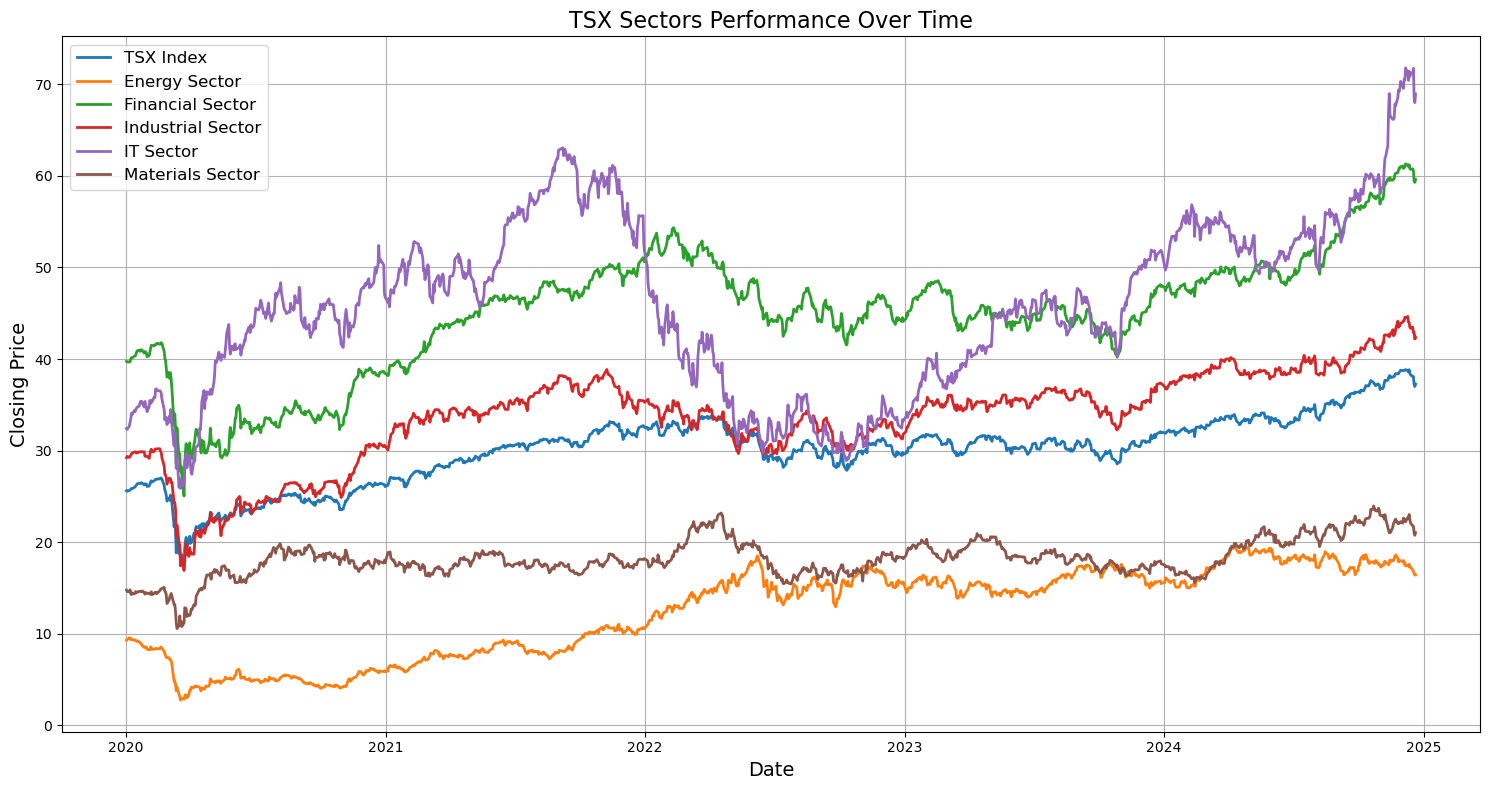

In [20]:
plt.figure(figsize=(15, 8))

plt.plot(tsx_data['timestamp'], tsx_data['close'], label='TSX Index', linewidth=2,)
plt.plot(energy_data['timestamp'], energy_data['close'], label='Energy Sector', linewidth=2)
plt.plot(financial_data['timestamp'], financial_data['close'], label='Financial Sector', linewidth=2)
plt.plot(industrial_data['timestamp'], industrial_data['close'], label='Industrial Sector', linewidth=2)
plt.plot(it_data['timestamp'], it_data['close'], label='IT Sector', linewidth=2)
plt.plot(materials_data['timestamp'], materials_data['close'], label='Materials Sector', linewidth=2)

plt.title('TSX Sectors Performance Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()

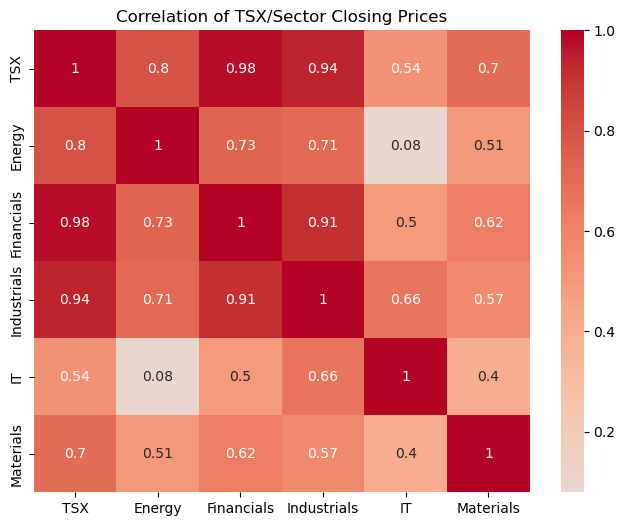

In [21]:
sector_data = pd.DataFrame({
    'TSX': tsx_data['close'],
    'Energy': energy_data['close'],
    'Financials': financial_data['close'],
    'Industrials': industrial_data['close'],
    'IT': it_data['close'],
    'Materials': materials_data['close']
})

correlation_matrix = sector_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of TSX/Sector Closing Prices')
plt.show()

In [22]:
# Calculate returns for all sectors
tsx_data['returns (%)'] = tsx_data['close'].pct_change() * 100
energy_data['returns (%)'] = energy_data['close'].pct_change() * 100
financial_data['returns (%)'] = financial_data['close'].pct_change() * 100
industrial_data['returns (%)'] = industrial_data['close'].pct_change() * 100
it_data['returns (%)'] = it_data['close'].pct_change() * 100
materials_data['returns (%)'] = materials_data['close'].pct_change() * 100

# Fill NaN values with 0 and round to 2 decimals
for data in [tsx_data, energy_data, financial_data, industrial_data, it_data, materials_data]:
    data['returns (%)'] = data['returns (%)'].round(2).fillna(0)

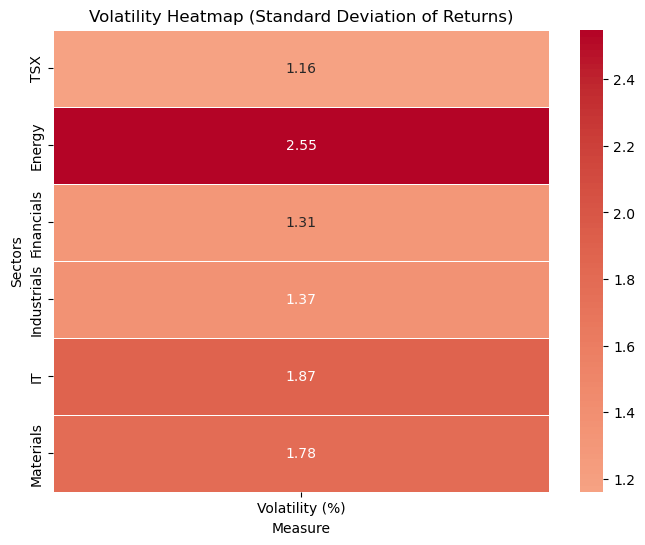

In [23]:
# Visualising the volatility heatmap

returns_data = pd.DataFrame({
    'TSX': tsx_data['returns (%)'],
    'Energy': energy_data['returns (%)'],
    'Financials': financial_data['returns (%)'],
    'Industrials': industrial_data['returns (%)'],
    'IT': it_data['returns (%)'],
    'Materials': materials_data['returns (%)']
})

# Calculate volatility (standard deviation of returns)
volatility = returns_data.std()

# Convert volatility data to a DataFrame for the heatmap
volatility_df = volatility.to_frame(name='Volatility (%)')

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(volatility_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, center=0)

# Add labels and title
plt.title("Volatility Heatmap (Standard Deviation of Returns)")
plt.xlabel("Measure")
plt.ylabel("Sectors")
plt.show()

In [24]:
# Calculating monthly data for comparison with macroeconomic indicators
tsx_monthly = tsx_data.resample('ME', on='timestamp')['close'].mean()
tsx_monthly.head()

timestamp
2020-01-31    26.111818
2020-02-29    26.379474
2020-03-31    20.892727
2020-04-30    21.572857
2020-05-31    22.774500
Freq: ME, Name: close, dtype: float64

In [47]:
# FX Data Processing
# Ensure 'Price' column is renamed to 'timestamp' and convert it to datetime
fx_data.rename(columns={'Price': 'timestamp'}, inplace=True)
fx_data['timestamp'] = pd.to_datetime(fx_data['timestamp'])

# Set the 'timestamp' column as the index
fx_data.set_index('timestamp', inplace=True)

# Align FX data to the end of the month
fx_data.index = fx_data.index.to_period('M').to_timestamp('M')

# Inflation Data Processing
# Ensure 'date' column is converted to datetime
inflation_data['date'] = pd.to_datetime(inflation_data['date'])

# Set the 'date' column as the index
inflation_data.set_index('date', inplace=True)

# Align Inflation data to the end of the month
inflation_data.index = inflation_data.index.to_period('M').to_timestamp('M')

# Verify the ranges after alignment
print("FX Data Range (aligned):", fx_data.index.min(), "-", fx_data.index.max())
print("Inflation Data Range (aligned):", inflation_data.index.min(), "-", inflation_data.index.max())

# Display sample data to verify alignment
fx_data

KeyError: 'timestamp'

In [46]:
# Check if the index is already set to 'date' and is in datetime format
if not isinstance(inflation_data.index, pd.DatetimeIndex):
    inflation_data.index = pd.to_datetime(inflation_data.index)

# Drop the "Unnamed: 0" column if it's not necessary
if 'Unnamed: 0' in inflation_data.columns:
    inflation_data.drop(columns=['Unnamed: 0'], inplace=True)

# Align Inflation data to the end of the month (if necessary)
inflation_data.index = inflation_data.index.to_period('M').to_timestamp('M')

# Verify the range and structure
inflation_data

,CPI,Inflation Rate (%)
date,,
2019-01-31,134.3,NaN
2019-02-28,134.7,NaN
2019-03-31,135.2,NaN
2019-04-30,135.6,NaN
2019-05-31,136.0,NaN
...,...,...
2024-07-31,161.2,2.479339
2024-08-31,161.3,1.895136
2024-09-30,161.3,1.702396


In [49]:
# Combine the datasets
combined_data = pd.DataFrame({
    'TSX': tsx_monthly,
    'FX': fx_data['Close'],  # Assuming 'Close' contains the relevant FX data
    'Inflation': inflation_data['CPI']  # Assuming 'CPI' contains the relevant inflation data
}).dropna()  # Drop rows with missing values

# Display the combined data
print(combined_data.head())
print(combined_data.info())

                  TSX        FX  Inflation
2020-01-31  26.111818  0.756928      137.5
2020-02-29  26.379474  0.748587      137.7
2020-03-31  20.892727  0.705283      136.3
2020-04-30  21.572857  0.720757      135.6
2020-05-31  22.774500  0.727289      135.4
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-01-31 to 2024-11-30
Freq: ME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TSX        59 non-null     float64
 1   FX         59 non-null     float64
 2   Inflation  59 non-null     float64
dtypes: float64(3)
memory usage: 1.8 KB
None


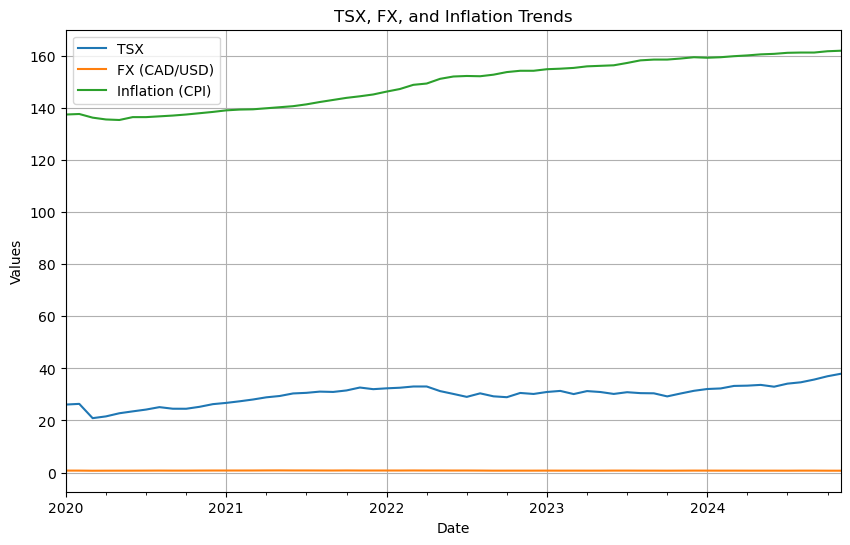

In [51]:
combined_data.plot(figsize=(10, 6))
plt.title("TSX, FX, and Inflation Trends")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend(["TSX", "FX (CAD/USD)", "Inflation (CPI)"])
plt.grid(True)
plt.show()

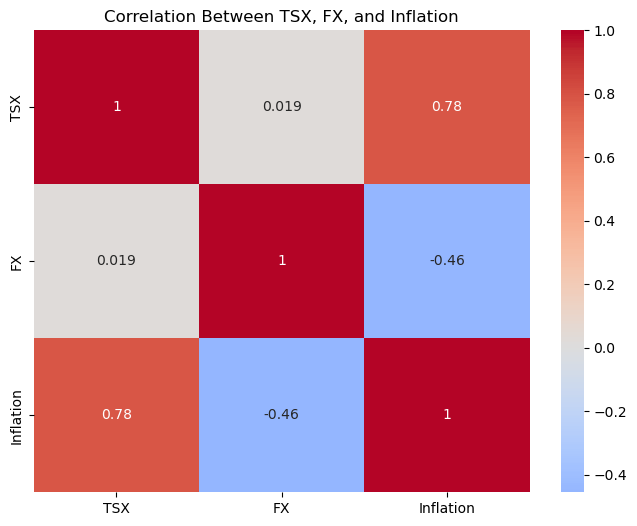

In [52]:
# Calculate correlation matrix
correlation_matrix = combined_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between TSX, FX, and Inflation')
plt.show()

In [3]:
app = Flask(__name__)

In [4]:
@app.route('/update_graph', methods=['POST'])
def update_graph():
    # Get the user-selected indicator from the dropdown
    selected_indicator = request.form['indicator']
    
    # Query data based on the selected indicator
    if selected_indicator == 'TSX':
        query = "SELECT timestamp, close AS value FROM tsx_daily"
    elif selected_indicator == 'FX':
        query = "SELECT timestamp, close AS value FROM fx_data"
    elif selected_indicator == 'Inflation':
        query = "SELECT timestamp, CPI AS value FROM CPI_Inflation"
    else:
        return jsonify({"error": "Invalid indicator"})
    
    # Execute the query
    df = pd.read_sql(query, conn)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Create a Plotly visualization
    fig = px.line(
        df,
        x=df.index,
        y='value',
        title=f"{selected_indicator} Over Time",
        labels={'x': 'Date', 'y': selected_indicator}
    )

    # Return the JSON representation of the Plotly figure
    return jsonify(fig.to_json())

In [5]:
@app.route('/')
def index_page():
    return render_template('index.html')

@app.route('/update_chart', methods=['POST'])
def update_chart():
    # Get the user-selected indicator from the dropdown
    selected_indicator = request.form['indicator']
    
    # Query the database or use the loaded DataFrame for the selected indicator
    if selected_indicator == 'TSX':
        data = tsx_data[['timestamp', 'close']]
    else:
        data = None  # Handle other indicators here

    # Generate a Plotly figure
    fig = px.line(data, x='timestamp', y='close', title=f'{selected_indicator} Over Time')

    # Return the JSON representation of the Plotly figure
    return jsonify(fig.to_json())

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\ammar\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
cursor.execute("PRAGMA table_info(fx_data)")
print(cursor.fetchall())

# Inspect CPI_Inflation table
cursor.execute("PRAGMA table_info(CPI_Inflation)")
print(cursor.fetchall())
conn.close()

[(0, 'Price', 'TEXT', 0, None, 0), (1, 'Adj Close', 'REAL', 0, None, 0), (2, 'Close', 'REAL', 0, None, 0), (3, 'High', 'REAL', 0, None, 0), (4, 'Low', 'REAL', 0, None, 0), (5, 'Open', 'REAL', 0, None, 0), (6, 'Volume', 'INTEGER', 0, None, 0)]
[(0, 'Unnamed: 0', 'INTEGER', 0, None, 0), (1, 'date', 'TEXT', 0, None, 0), (2, 'CPI', 'REAL', 0, None, 0), (3, 'Inflation Rate (%)', 'REAL', 0, None, 0)]


In [7]:
query = "SELECT Price AS timestamp, Close AS value FROM fx_data"
query = "SELECT date AS timestamp, CPI AS value FROM CPI_Inflation"